In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from math import sqrt
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Flatten, BatchNormalization, Activation # type: ignore
from scikeras.wrappers import KerasClassifier  # type: ignore
from tensorflow.keras.utils import to_categorical# type: ignore

from keras import regularizers


In [3]:
# Load and preprocess the dataset
Features = pd.read_csv('D:\\ML PROJECT\\dataset.csv')

# Shuffle the dataset
temp = shuffle(Features)

# Split into train and test sets (80% train, 20% test)
df = np.random.rand(len(temp)) < 0.8
train = temp[df]
test = temp[~df]

In [4]:
# Separate features and labels
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]


In [5]:
# Convert to numpy arrays
X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

In [6]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

c:\Users\sathv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sathv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# Expand dimensions for LSTM model (add a channel dimension)
x_train = np.expand_dims(X_train, axis=2)
x_test = np.expand_dims(X_test, axis=2)

In [8]:
# Print shapes
print('Train dimension:', x_train.shape)
print('Test dimension:', x_test.shape)
print('Train labels dimension:', y_train.shape)
print('Test labels dimension:', y_test.shape)

Train dimension: (1163, 50, 1)
Test dimension: (277, 50, 1)
Train labels dimension: (1163, 8)
Test labels dimension: (277, 8)


In [9]:
# Define LSTM model
model = Sequential()

model.add(BatchNormalization(axis=-1, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5)))
model.add(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5)))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(8))  # Adjust based on number of classes
model.add(Activation('softmax'))

c:\Users\sathv\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 50, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        51,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,038,348 (3.96 MB)

 Trainable params: 1,038,090 (3.96 MB)

 Non-trainable params: 258 (1.01 KB)

In [12]:
history = model.fit(x_train, y_train, batch_size=256, epochs=1000, validation_data=(x_test, y_test), shuffle=True)

# Evaluate the model
print("Accuracy of our model on test data: ", model.evaluate(x_test, y_test)[1] * 100, "%")


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 759ms/step - accuracy: 0.1781 - loss: 2.0571 - val_accuracy: 0.1336 - val_loss: 2.1414
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - accuracy: 0.2101 - loss: 2.0177 - val_accuracy: 0.1336 - val_loss: 2.1770
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 926ms/step - accuracy: 0.1544 - loss: 2.0608 - val_accuracy: 0.1336 - val_loss: 2.0969
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2043 - loss: 2.0095 - val_accuracy: 0.1336 - val_loss: 2.0752
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2109 - loss: 1.9995 - val_accuracy: 0.1336 - val_loss: 2.3004
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 835ms/step - accuracy: 0.1975 - loss: 2.0916 - val_accuracy: 0.1336 - val_loss: 2.1335
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 852ms/step - accuracy: 0.1752 - loss: 2.0350 - val_accuracy: 0.1444 - val_loss: 2.0609
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 955ms/step - accuracy: 0.1959 - loss: 1.9918 - val_accuracy: 0.1336 -

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.2014 - loss: 3.3122
Accuracy of our model on test data:  19.346517324447632 %


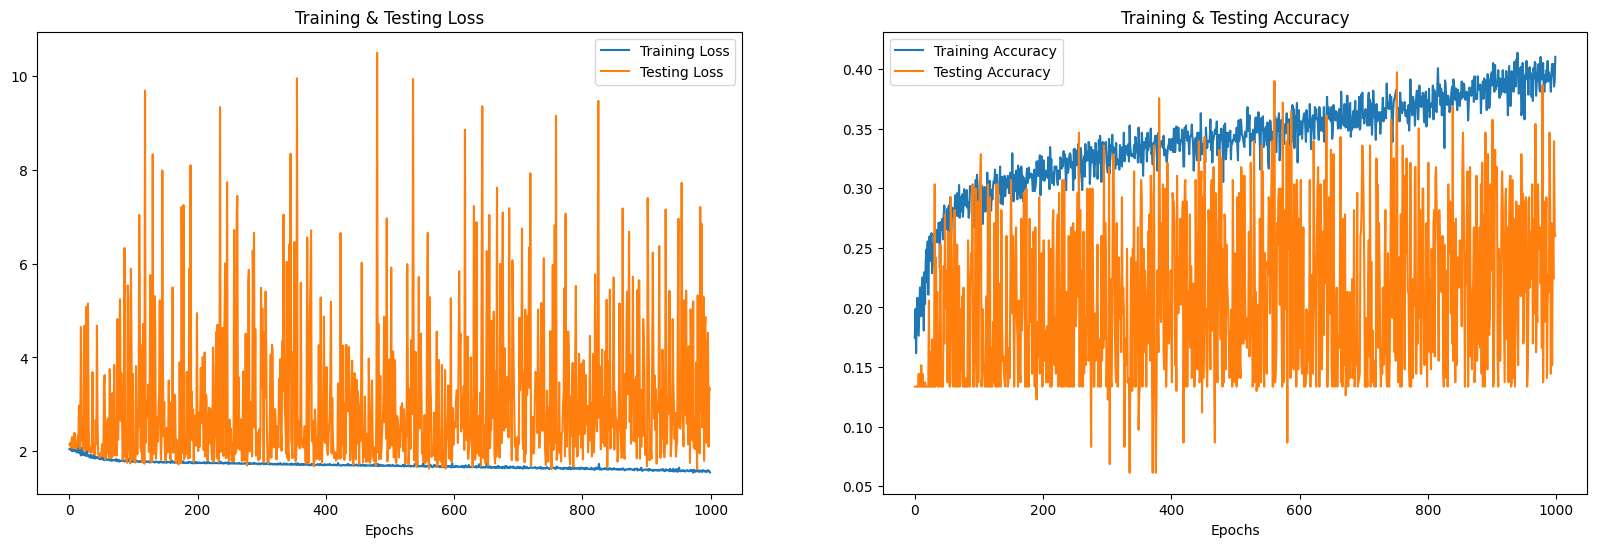

In [13]:
print("Accuracy of our model on test data: ", model.evaluate(x_train, y_train)[1] * 100, "%")
# Plot training and testing accuracy and loss
epochs = range(1000)
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plot training & testing accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()


In [14]:
# Save the trained model
best_model_path = 'D:\\ML PROJECT\\Best models\\emotion_classification_model_LSTM.keras'  # Define your model file name
model.save(best_model_path)  # Save the model
print(f'Model saved to {best_model_path}')

Model saved to D:\ML PROJECT\Best models\emotion_classification_model_LSTM.keras


In [15]:
import tensorflow as tf #type: ignore
best_model = tf.keras.models.load_model('D:\\ML PROJECT\\Best models\\emotion_classification_model_LSTM.keras')

In [16]:
from tensorflow.keras.models import load_model  # type: ignore

# Load the model
loaded_model = load_model(best_model_path)
print('Model Loaded')

Model Loaded
